In [ ]:
import warnings
import itertools 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pylab import rcParams

import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tc = pd.read_excel('/content/drive/MyDrive/Consulta_TC.xlsx')

In [ ]:
data2=tc.set_index('Fecha')

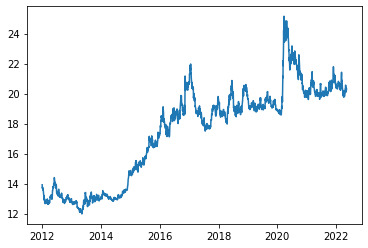

In [ ]:
#gráficamos para ver si visualmente se puede identidficar tenden
figsize=(20, 25)
plt.plot(data2);

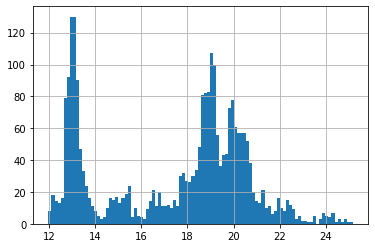

In [ ]:
tc['TC_venta'].hist(bins=100);

In [ ]:
#definimos el df
df = tc[['Fecha', 'TC_venta']].set_index('Fecha')
df.head()

,TC_venta
Fecha,
2012-01-02,13.9250
2012-01-03,13.7200
2012-01-04,13.6900
2012-01-05,13.7592
2012-01-06,13.7628


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2602 entries, 0 to 2601
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Fecha     2602 non-null   datetime64[ns]
 1   TC_venta  2602 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 40.8 KB


In [ ]:
def viewing_stationarity(df, window=5):
  """
  Esta función genera un plot para una serie de tiempo
  con su media móvil y su desviación estándar.
  """

  rolmean = df.rolling(window=window).mean()
  rolstd = df.rolling(window=window).std()

  fig = plt.figure(figsize=(10, 5))
  time_series = plt.plot(df, color='blue', label='original')
  mean = plt.plot(rolmean, color='red', label='media móvil')
  std = plt.plot(rolstd, color='green', label='desviación estándar móvil')
  plt.legend(loc='best')
  plt.show();

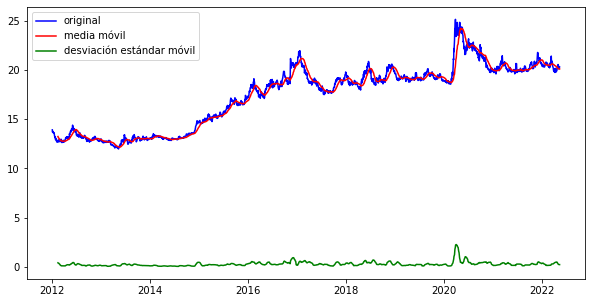

In [ ]:
#Graficamos la media movil y la desviación estándar para ver si hay indicios de manera gráfica de tendencia la serie.
#Se observa que con una ventana de 30 días el comportamiento de la media movil y la original es casi el mismo.
viewing_stationarity(df, window=30)

In [ ]:
class Stationary:
  def __init__(self, significance=0.05):
    self.significance_level = significance
    self.pvalue = None
    self.is_stationary = None

  def ADF(self, values):
    result = adfuller(values, autolag='AIC')

    format_results = pd.Series(result[:4], 
                                index=['Statistic', 'P-value',
                                      'Num of Lags', 'Observations'])
    for k,v in result[4].items():
      format_results[f'Critical Value {k}'] = v

    return format_results

In [ ]:
#Se realiza la prueba de ADF, que es una prueba de raíz unitaria, la cual tiene como H0: La serie no es estacionaria.
#Con base en los resultados de esta, no se rechaza la H0, por lo que hay evidencia de no estacionariedad.
adf_test = Stationary()
adf_test.ADF(df['TC_venta'].values).round(5)

Statistic               -1.27788
P-value                  0.63923
Num of Lags              0.00000
Observations          2601.00000
Critical Value 1%       -3.43287
Critical Value 5%       -2.86265
Critical Value 10%      -2.56736
dtype: float64

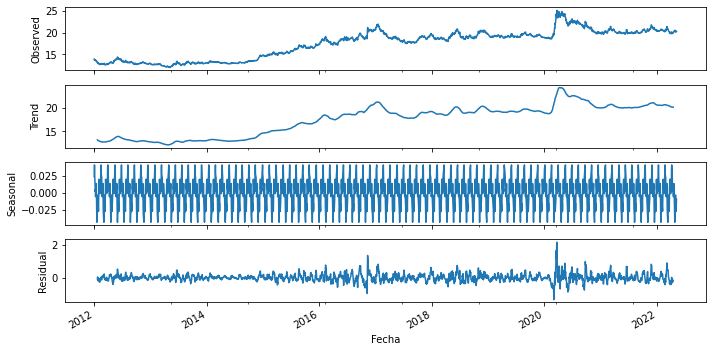

In [ ]:
#Descomponemos la serie de tiempo
rcParams['figure.figsize'] = 10, 5

decomposition = sm.tsa.seasonal_decompose(df['TC_venta'], freq=30)
fig = decomposition.plot()
plt.show();

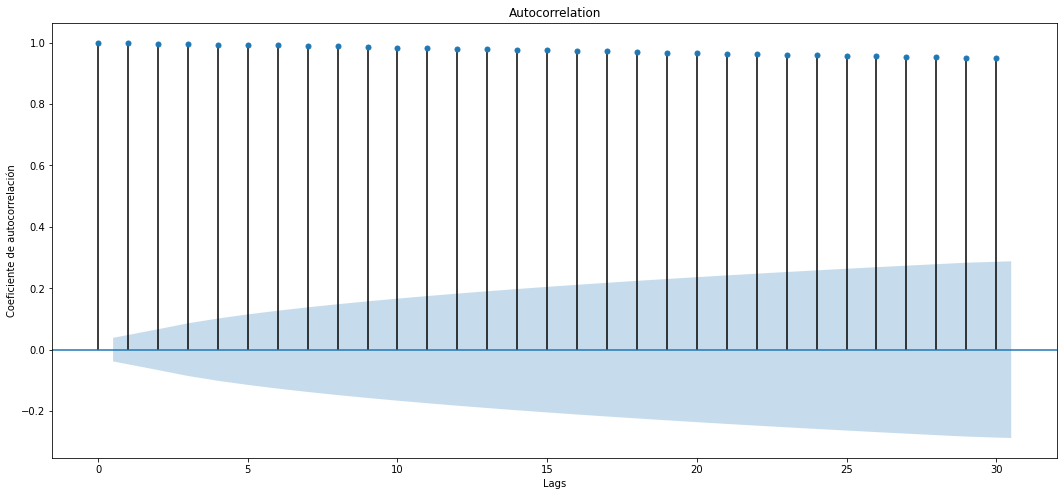

In [ ]:
#Realizamos la función de autocorrelación 
tsaplots.plot_acf(df['TC_venta'].values.squeeze(), lags=30)
plt.xlabel('Lags')
plt.ylabel('Coeficiente de autocorrelación')
plt.show()

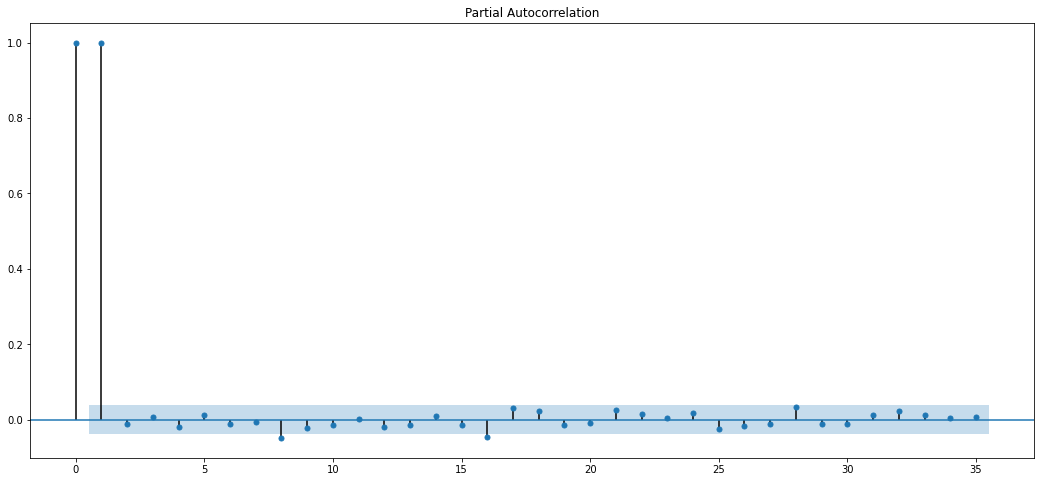

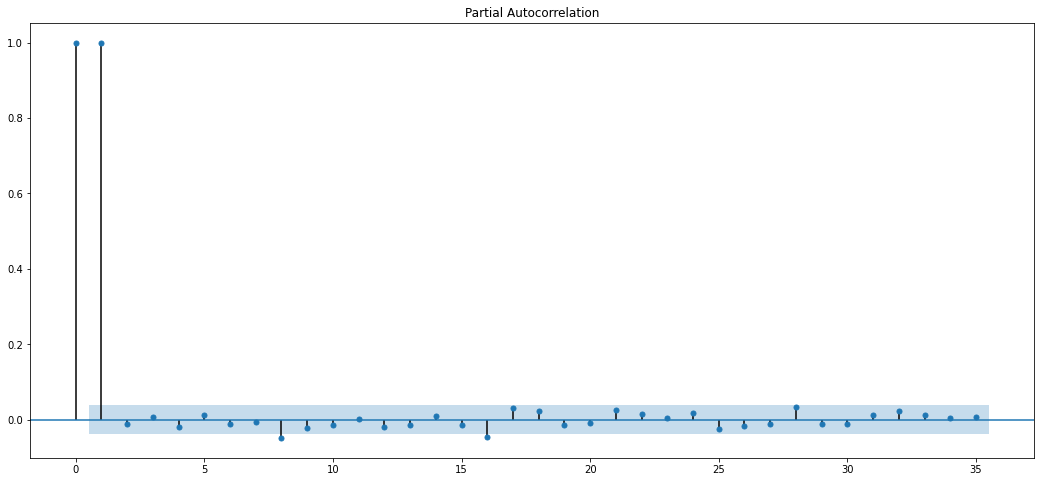

In [ ]:
tsaplots.plot_pacf(df['TC_venta'])

In [ ]:
#Ya que la serie no es estacionaria, utilizamos primeras diferencias para ver si la serie se hace estacionaria.
df['TC_venta_shift1'] = df['TC_venta'].shift(1)#Creamos una variable con la serie recorrida un período
df.head()

,Fecha,TC_venta,TC_venta_shift1
0,2012-01-02,13.9250,NaN
1,2012-01-03,13.7200,13.9250
2,2012-01-04,13.6900,13.7200
3,2012-01-05,13.7592,13.6900
4,2012-01-06,13.7628,13.7592


In [ ]:
#Obtenemos la primra diferencia yt-yt-1
df['TC_diff'] = df['TC_venta'] - df['TC_venta_shift1']
df.head()

,Fecha,TC_venta,TC_venta_shift1,TC_diff
0,2012-01-02,13.9250,NaN,NaN
1,2012-01-03,13.7200,13.9250,-0.2050
2,2012-01-04,13.6900,13.7200,-0.0300
3,2012-01-05,13.7592,13.6900,0.0692
4,2012-01-06,13.7628,13.7592,0.0036


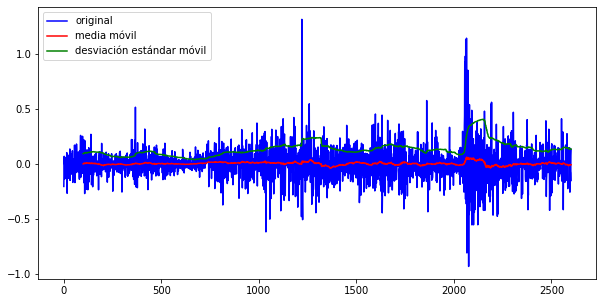

Statistic              -50.763797
P-value                  0.000000
Num of Lags              0.000000
Observations          2600.000000
Critical Value 1%       -3.432868
Critical Value 5%       -2.862652
Critical Value 10%      -2.567362
dtype: float64

In [ ]:
#Aplicamos la función viewing_stationarity para hacerle a la serie en diferencias prueba de ADF.
viewing_stationarity(df['TC_diff'].dropna(), window=100)
adf_test = Stationary()
adf_test.ADF(df['TC_diff'].dropna().values).round(6)
#Con base en la gráfica podemos observar que la serie ya no tiene tendencia. 
#Asimismo, esto se confirma con la ADF, el p.value de esta es menor a 0.05 por lo tanto, se rechaza la hipótesis nula
#es decir, la serie es estacionaria. 

In [ ]:
data = df[['Fecha', 'TC_diff']].dropna()
data

,Fecha,TC_diff
1,2012-01-03,-0.2050
2,2012-01-04,-0.0300
3,2012-01-05,0.0692
4,2012-01-06,0.0036
5,2012-01-09,-0.0128
...,...,...
2597,2022-05-03,-0.0680
2598,2022-05-04,-0.0820
2599,2022-05-05,-0.1560
2600,2022-05-06,0.0750


In [ ]:
data.shape[0]*.9 #Cálculamos el número de observaciones correspondinetes al 90% para el entrenamiento

2340.9

In [ ]:
data.isnull().sum()

Fecha      0
TC_diff    0
dtype: int64

In [ ]:
data.set_index('Fecha', inplace=True, drop=True)

In [ ]:
split_date = '2021-04-30'
# train = data.loc[data.index <= split_date].copy()
# test = data.loc[data.index > split_date].copy()

In [ ]:
# Definimos los rangos en los que vamos a probar PDQ

p = d = q = range(0, 5)
p, d, q

(range(0, 5), range(0, 5), range(0, 5))

In [ ]:
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (1, 3, 4),
 (1, 4, 0),
 (1, 4, 1),
 (1, 4, 2),
 (1, 4, 3),
 (1, 4, 4),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 3, 0),
 (2, 3, 1),
 (2, 3, 2),
 (2, 3, 3),
 (2, 3, 4),
 (2, 4, 0),
 (2, 4, 1),
 (2, 4, 2),
 (2, 4, 3),
 (2, 4, 4),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3,

In [ ]:
model = list()
aic = list()

for param in pdq:
  try:
    mod = SARIMAX(data['TC_diff'],
                  order=param,
                  enforce_stationarity=False)
    results = mod.fit()
    model.append(param)
    aic.append(results.aic) # Akaike Information Criterion
    print('ARIMA{}-AIC{}'.format(param, results.aic))
  except:
    print('')
    print('No pude correr el modelo')
    continue

ARIMA(0, 0, 0)-AIC-2491.705940135415
ARIMA(0, 0, 1)-AIC-2487.8403463111663
ARIMA(0, 0, 2)-AIC-2484.2196561394376
ARIMA(0, 0, 3)-AIC-2480.7817689298463
ARIMA(0, 0, 4)-AIC-2477.7274337449103
ARIMA(0, 1, 0)-AIC-700.2788969067819
ARIMA(0, 1, 1)-AIC-2479.582565362037
ARIMA(0, 1, 2)-AIC-2475.5996266434026
ARIMA(0, 1, 3)-AIC-2471.8704259325777
ARIMA(0, 1, 4)-AIC-2468.0557864377356
ARIMA(0, 2, 0)-AIC2145.3458159246497
ARIMA(0, 2, 1)-AIC-688.9672524458202
ARIMA(0, 2, 2)-AIC-2446.91568887832
ARIMA(0, 2, 3)-AIC-2445.5010447418126
ARIMA(0, 2, 4)-AIC-2445.2605472021905
ARIMA(0, 3, 0)-AIC5261.989271855859
ARIMA(0, 3, 1)-AIC2154.3303716570754
ARIMA(0, 3, 2)-AIC-664.0460404856472
ARIMA(0, 3, 3)-AIC-2361.8419078240945
ARIMA(0, 3, 4)-AIC-2379.245925188086
ARIMA(0, 4, 0)-AIC8502.281136928854
ARIMA(0, 4, 1)-AIC5268.584641474783
ARIMA(0, 4, 2)-AIC2169.773623979099
ARIMA(0, 4, 3)-AIC-588.9170017755091
ARIMA(0, 4, 4)-AIC-1724.8165299077837
ARIMA(1, 0, 0)-AIC-2489.760110352964
ARIMA(1, 0, 1)-AIC-2486.88925459

In [ ]:
df_modelos = pd.DataFrame(zip(model, aic), columns=['model', 'aic'])
df_modelos.sort_values('aic').head()

,model,aic
0,"(0, 0, 0)",-2491.705940
25,"(1, 0, 0)",-2489.760110
1,"(0, 0, 1)",-2487.840346
26,"(1, 0, 1)",-2486.889255
50,"(2, 0, 0)",-2485.964639


In [ ]:
AR= SARIMAX(data['TC_diff'], 
                    order=(1, 0, 0), 
                    enforce_stationarity=False)

results = AR.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                TC_diff   No. Observations:                 2601
Model:               SARIMAX(1, 0, 0)   Log Likelihood                1246.880
Date:                Fri, 13 May 2022   AIC                          -2489.760
Time:                        14:06:33   BIC                          -2478.034
Sample:                             0   HQIC                         -2485.511
                               - 2601                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0046      0.009      0.491      0.624      -0.014       0.023
sigma2         0.0224      0.000     87.211      0.000       0.022       0.023
===================================================================================
Ljung-Box (Q):                       53.87   Jarque-Bera (JB):             10383.47
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               5.04   Skew:                             0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

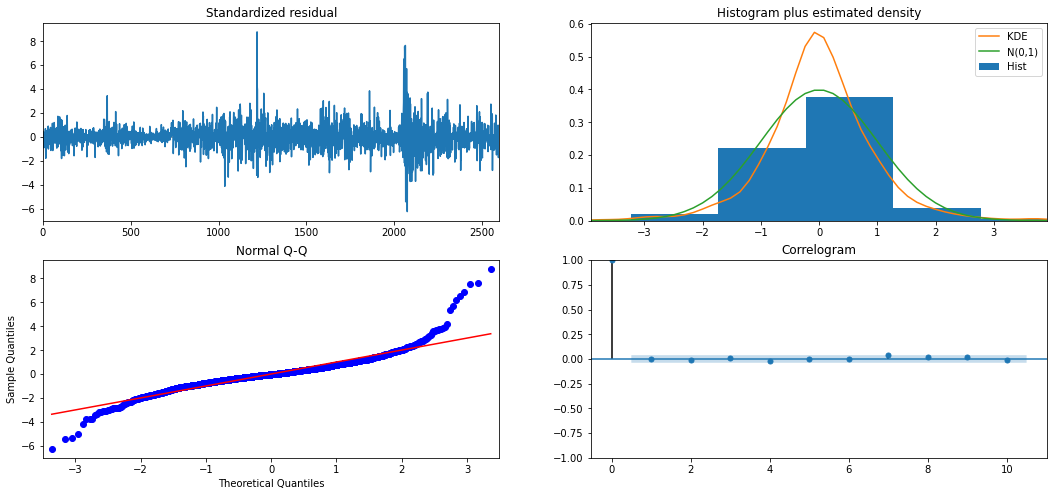

In [ ]:
results.plot_diagnostics()
plt.show()

In [ ]:
ARMA= SARIMAX(data, 
                    order=(1, 0, 1), 
                    enforce_stationarity=False)

results2 = ARMA.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                TC_diff   No. Observations:                 2601
Model:               SARIMAX(1, 0, 1)   Log Likelihood                1246.445
Date:                Fri, 13 May 2022   AIC                          -2486.889
Time:                        14:06:40   BIC                          -2469.301
Sample:                             0   HQIC                         -2480.516
                               - 2601                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8162      0.136     -5.982      0.000      -1.084      -0.549
ma.L1          0.8309      0.134      6.210      0.000       0.569       1.093
sigma2         0.0224      0.000     86.374      0.000       0.022       0.023
===================================================================================
Ljung-Box (Q):                       52.17   Jarque-Bera (JB):             10242.63
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               5.03   Skew:                             0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

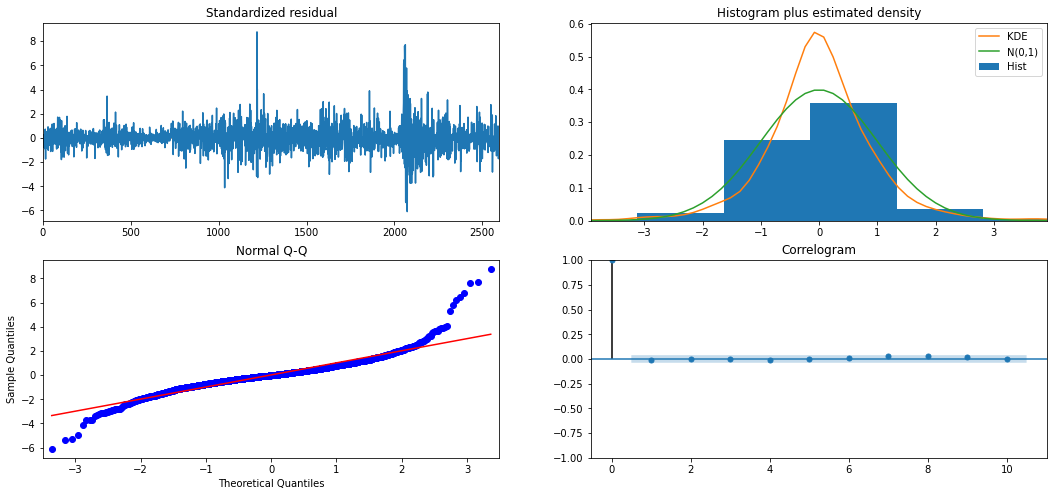

In [ ]:
results2.plot_diagnostics()
plt.show()

In [ ]:
#Predicciones 
data.shape[0] * 0.9

2340.9

In [ ]:
data.reset_index().iloc[2341, 0]

Timestamp('2021-04-30 00:00:00')

In [ ]:
start = data.reset_index().iloc[2342, 0]
end = data.reset_index().iloc[-1, 0]

start, end

(Timestamp('2021-05-03 00:00:00'), Timestamp('2022-05-09 00:00:00'))

In [ ]:
pred = results2.predict(start=start, end=end)
pred_ci = results2.get_prediction(start=start, end=end).conf_int()

In [ ]:
df_pred = pd.DataFrame(pred, index=data.iloc[2342:].index, columns=['TC_diff'])

In [ ]:
df_pred

,TC_diff
Fecha,
2021-05-03,-0.002711
2021-05-04,0.004176
2021-05-05,-0.003719
2021-05-06,0.002679
2021-05-07,-0.001859
...,...
2022-05-03,0.004890
2022-05-04,-0.005061
2022-05-05,0.003001


In [ ]:
split_date = '2021-04-30'
# train = data.loc[data.index <= split_date].copy()
# test = data.loc[data.index > split_date].copy()
# 

In [ ]:
df.set_index('Fecha', inplace=True, drop=True)

In [ ]:
test = df.loc[df.index > split_date].copy().dropna()

In [ ]:
test['forecast_diff'] = df_pred['TC_diff']

In [ ]:
test['Estimacion'] = test['forecast_diff'] + test['TC_venta']

In [ ]:
test

,TC_venta,TC_venta_shift1,TC_diff,forecast_diff,Estimacion
Fecha,,,,,
2021-05-03,20.272,20.141,0.131,-0.002711,20.269289
2021-05-04,20.255,20.272,-0.017,0.004176,20.259176
2021-05-05,20.227,20.255,-0.028,-0.003719,20.223281
2021-05-06,20.252,20.227,0.025,0.002679,20.254679
2021-05-07,19.938,20.252,-0.314,-0.001859,19.936141
...,...,...,...,...,...
2022-05-03,20.347,20.415,-0.068,0.004890,20.351890
2022-05-04,20.265,20.347,-0.082,-0.005061,20.259939
2022-05-05,20.109,20.265,-0.156,0.003001,20.112001


In [ ]:
pred_ci['lower_TC_diff'] = pred_ci['lower TC_diff'] + test['TC_venta']
pred_ci['upper_TC_diff'] = pred_ci['upper TC_diff'] + test['TC_venta']
pred_ci

,lower TC_diff,upper TC_diff,lower_TC_diff,upper_TC_diff
Fecha,,,,
2021-05-03,-0.296226,0.290804,19.975774,20.562804
2021-05-04,-0.289339,0.297691,19.965661,20.552691
2021-05-05,-0.297234,0.289796,19.929766,20.516796
2021-05-06,-0.290836,0.296194,19.961164,20.548194
2021-05-07,-0.295374,0.291656,19.642626,20.229656
...,...,...,...,...
2022-05-03,-0.288625,0.298405,20.058375,20.645405
2022-05-04,-0.298576,0.288454,19.966424,20.553454
2022-05-05,-0.290513,0.296516,19.818487,20.405516


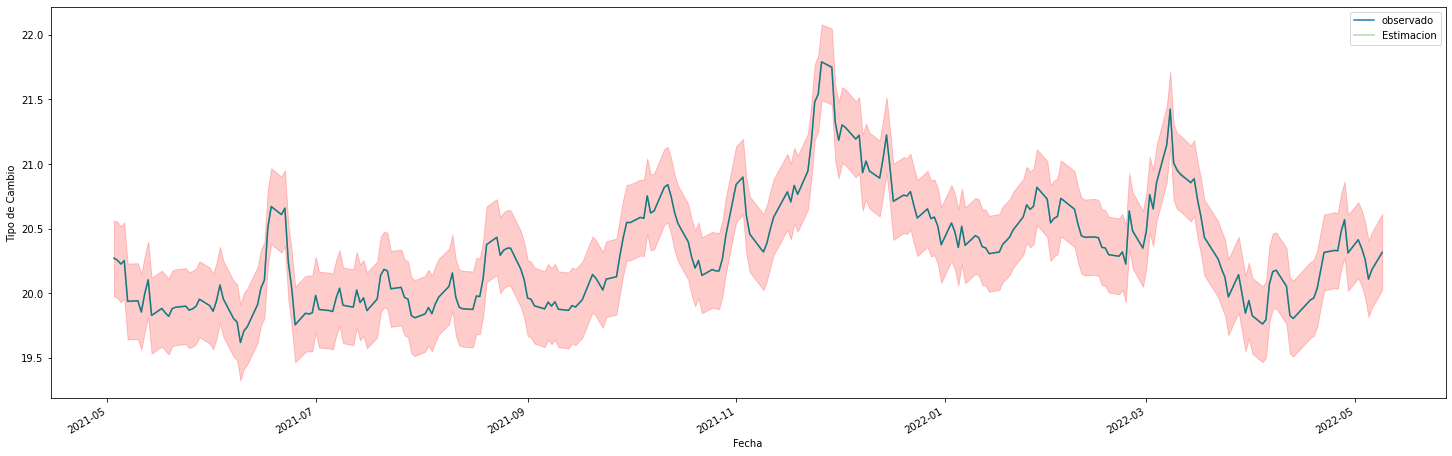

In [ ]:
rcParams['figure.figsize'] = 25, 8

ax = test['TC_venta'].plot(label='observado')
test['Estimacion'].plot(c='g', alpha=0.3) 
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 2], 
                pred_ci.iloc[:, 3], 
                color='r', alpha=0.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Tipo de Cambio')
plt.legend()
plt.show()

Text(0.5, 1.0, 'estimada')

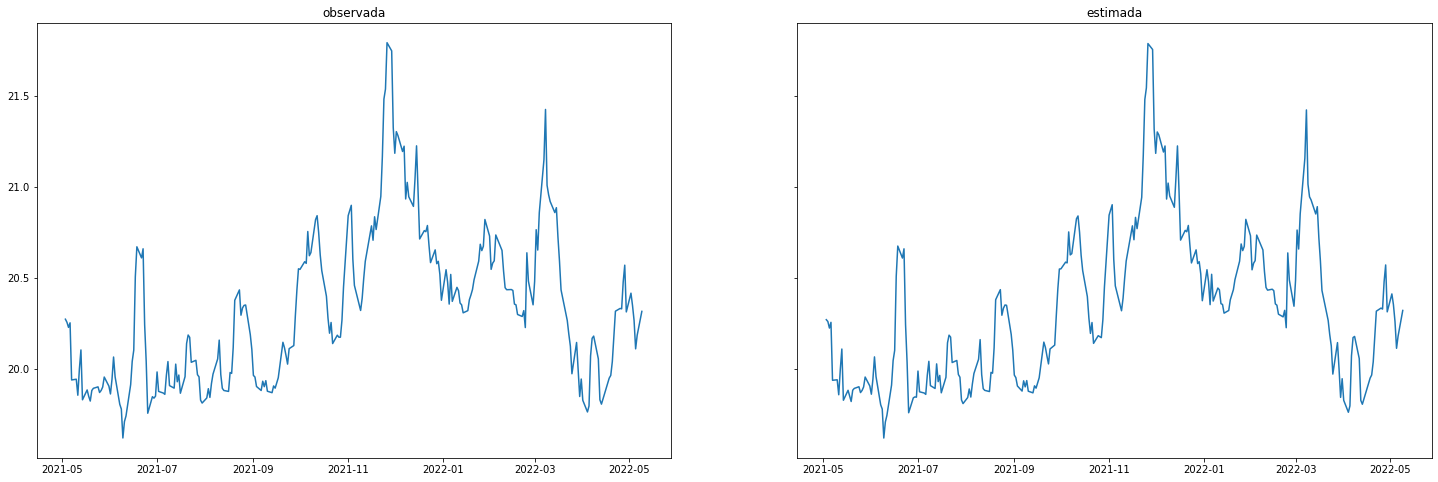

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
y=test['TC_venta']
y_hat=test['Estimacion']
ax1.plot(y)
ax1.set_title('observada')
ax2.plot(y_hat)
ax2.set_title('estimada')


In [ ]:
from sklearn.metrics import mean_squared_error as mse
#Con el método mse calculamos la media de los errores al cuadrado, esperamos que este valor sea cercano a cero
mse(test['TC_venta'], test['Estimacion'])**0.5

0.0029562930158330575

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(test['TC_venta'], test['Estimacion'])*100
#En promedio el error esta errado en un 0.011%

0.011122632635355022

PREDICCIÓN AL FUTURO

In [ ]:
pred_uc = list(results2.forecast(steps=21))
print(pred_uc)

[-0.002294556904551645, 0.001872848201877874, -0.0015286438877673253, 0.0012476996978534511, -0.0010183892720084893]


In [ ]:
ultimo = test['TC_venta'][-1]
pronostico=[]
for i in pred_uc:
  ultimo +=i
  pronostico.append(ultimo)



In [ ]:
pronostico = pd.DataFrame(pronostico)

In [ ]:
date = pd.date_range(start='2022-05-10 00:00:00', 
                        end='2022-05-30 00:00:00', 
                        freq='D')
date

DatetimeIndex(['2022-05-10', '2022-05-11', '2022-05-12', '2022-05-13',
               '2022-05-14'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
date_2 = pd.Series(date, name='date')
date_2

0   2022-05-10
1   2022-05-11
2   2022-05-12
3   2022-05-13
4   2022-05-14
Name: date, dtype: datetime64[ns]

In [ ]:
df_pronostico2= pd.concat([pronostico, date_2], axis=1).set_index('date').round(3)
df_pronostico2.rename(columns={0: 'Forecast'}, inplace=True)
df_pronostico2


,Forecast
date,
2022-05-10,20.313
2022-05-11,20.315
2022-05-12,20.313
2022-05-13,20.314
2022-05-14,20.313


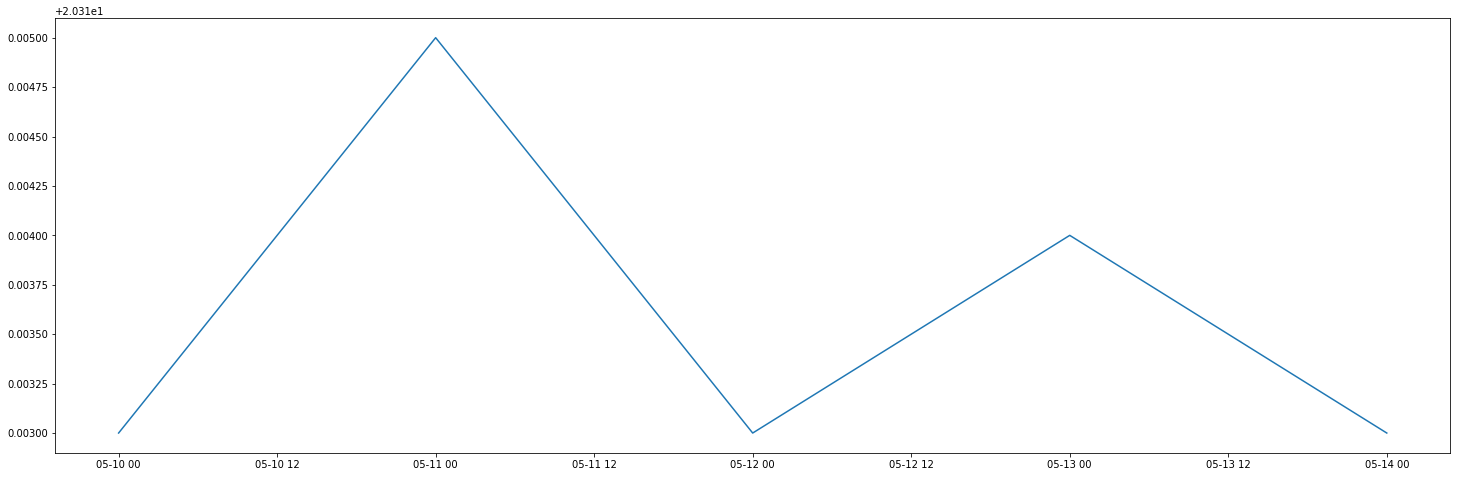

In [ ]:
plt.plot(df_pronostico2['Forecast']);

In [ ]:
df_observada = test[['TC_venta']]
df_observada

,TC_venta
Fecha,
2021-05-03,20.272
2021-05-04,20.255
2021-05-05,20.227
2021-05-06,20.252
2021-05-07,19.938
...,...
2022-05-03,20.347
2022-05-04,20.265
2022-05-05,20.109


In [ ]:
Forecast = pd.concat([df_observada['TC_venta'], df_pronostico2['Forecast']], axis=0)

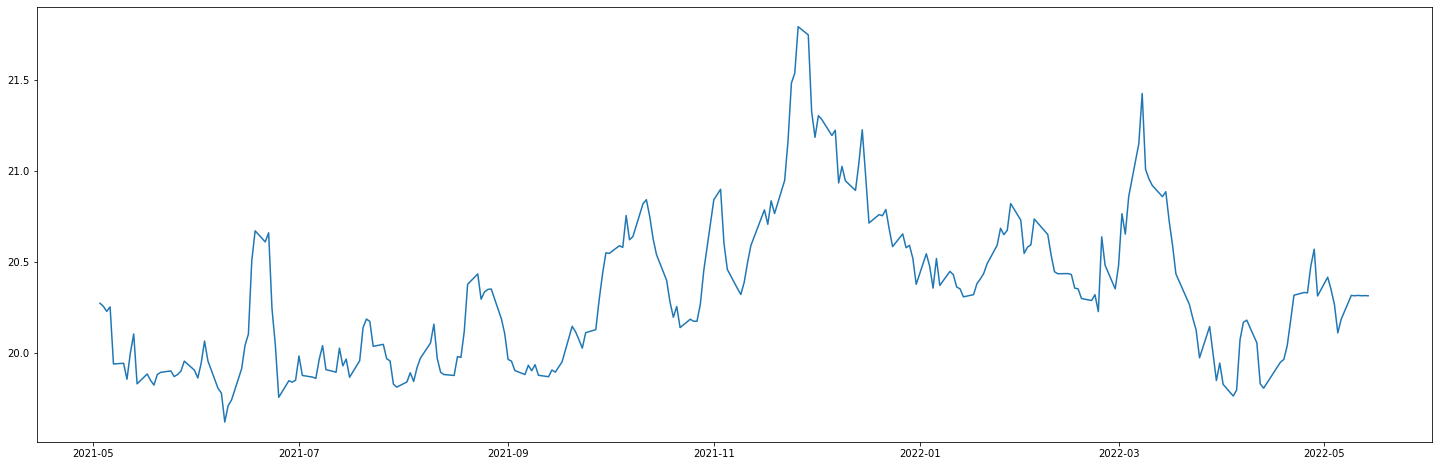

In [ ]:
plt.plot(Forecast);

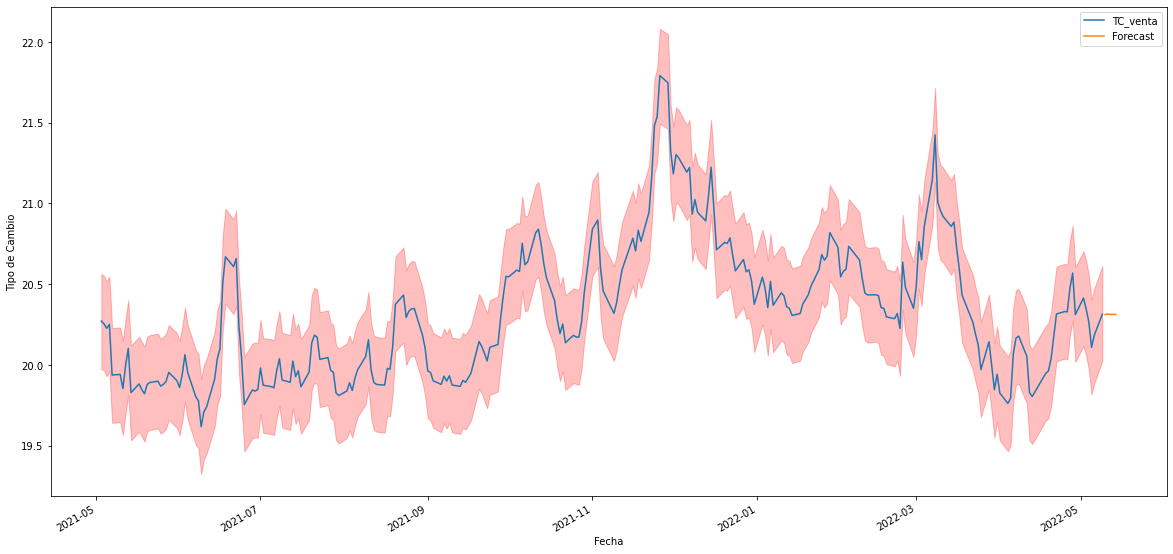

In [ ]:
rcParams['figure.figsize'] = 25, 8

ax = df_observada.iloc[:].plot(label='Observado', figsize=(20, 10))
df_pronostico2.iloc[:].plot(ax=ax, label='Predicción futura')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 2],
                pred_ci.iloc[:, 3], color='r', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Tipo de Cambio')
plt.legend()
plt.show();

In [ ]:
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [ ]:
forecast = inverse_difference(df['TC_venta'], tc_estimado, -259)

NameError: ignored

In [ ]:
print(forecast)

In [ ]:
test['forecast'] = forecast

In [ ]:
test